In [ ]:
!pip install -U scikit-learn scikeras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 70.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.


In [ ]:
!pip install scikeras


In [ ]:
import sklearn
import scikeras

print("scikit-learn version:", sklearn.__version__)
print("scikeras version:", scikeras.__version__)
#scikit-learn >= 1.2.0
#scikeras >= 0.10.0


scikit-learn version: 1.7.0
scikeras version: 0.13.0


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 14.9 MB/s eta 0:00:00


In [ ]:
# Consolidated version to repeat the ANN Optuna-based pipeline for lag = 1 to 14

import optuna
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import random

# Set seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load data
sheet_id = "1j_Euo80PrGckVDVr2hTG9zZebxJD0TSC"
sheet_name = "Sheet1"
csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df = pd.read_csv(csv_url)
df = df.set_index('Date').drop(columns=["YEAR", "MO", "DY"])
df = df[["WS10M"]].astype(float)

# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df

# Run the modeling pipeline for each lag
def run_model_for_lag(lag):
    print(f"\n========= Running Model for Lag {lag} =========")
    df_lagged = create_lagged_features(df, lag).dropna()

    train_size = int(len(df_lagged) * 0.8)
    train, test = df_lagged.iloc[:train_size], df_lagged.iloc[train_size:]

    X_train, y_train = train.drop(columns=["WS10M"]), train["WS10M"]
    X_test, y_test = test.drop(columns=["WS10M"]), test["WS10M"]

    scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

    X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    y_train_series = pd.Series(y_train_scaled)

    def create_ann_model(trial, X):
        model = Sequential()
        model.add(Dense(trial.suggest_int("input_units", 16, 128, step=16),
                        input_dim=X.shape[1],
                        activation=trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])))
        for i in range(trial.suggest_int("num_layers", 1, 3)):
            model.add(Dense(trial.suggest_int(f"n_units_{i}", 16, 128, step=16),
                            activation=trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])))
            model.add(Dropout(trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)))
        model.add(Dense(1))
        optimizer = {"Adam": Adam, "SGD": SGD, "RMSprop": RMSprop}[trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])]()
        model.compile(optimizer=optimizer, loss='mean_squared_error')
        return model

    def objective(trial):
        tscv = TimeSeriesSplit(n_splits=3)
        batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
        epochs = trial.suggest_int("epochs", 10, 50, step=10)
        val_losses = []
        for train_idx, val_idx in tscv.split(X_train_df):
            X_t, X_v = X_train_df.iloc[train_idx], X_train_df.iloc[val_idx]
            y_t, y_v = y_train_series.iloc[train_idx], y_train_series.iloc[val_idx]
            model = create_ann_model(trial, X_t)
            model.fit(X_t, y_t, epochs=epochs, batch_size=batch_size, verbose=0)
            val_loss = model.evaluate(X_v, y_v, verbose=0)
            val_losses.append(val_loss)
        return np.mean(val_losses)

    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=SEED))
    study.optimize(objective, n_trials=15)
    best_params = study.best_params
    print("Best Params:", best_params)

    # Final model training
    model = Sequential()
    model.add(Dense(best_params['input_units'], input_dim=X_train_df.shape[1], activation=best_params['activation']))
    for i in range(best_params['num_layers']):
        model.add(Dense(best_params[f'n_units_{i}'], activation=best_params['activation']))
        model.add(Dropout(best_params[f'dropout_rate_{i}']))
    model.add(Dense(1))
    optimizer = {"Adam": Adam(), "SGD": SGD(), "RMSprop": RMSprop()}[best_params['optimizer']]
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    history = model.fit(X_train_df, y_train_series, epochs=best_params['epochs'],
                        batch_size=best_params['batch_size'], validation_split=0.1, verbose=0)

    # Predict
    X_test_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
    predictions_scaled = model.predict(X_test_df)
    predictions = scaler_y.inverse_transform(predictions_scaled)
    y_test_inv = scaler_y.inverse_transform(y_test_scaled)

    # Metrics
    mse = mean_squared_error(y_test_inv, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_inv, predictions)
    mape = np.mean(np.abs((y_test_inv - predictions) / y_test_inv)) * 100
    r2 = r2_score(y_test_inv, predictions)

    print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%, R²: {r2:.4f}")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_inv, label="Actual", linestyle="--")
    plt.plot(predictions, label="Predicted")
    plt.title(f"Lag {lag} - Actual vs Predicted")
    plt.xlabel("Samples")
    plt.ylabel("WS10M")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Run the loop for lag = 1 to 14
for lag in range(1, 15):
    run_model_for_lag(lag)



Output hidden; open in https://colab.research.google.com to view.

# 1

Original DataFrame:
                     WS10M
Date                      
2013-01-01 00:00:00   3.99
2013-01-02 00:00:00   4.25
2013-01-03 00:00:00   4.75
2013-01-04 00:00:00   5.74
2013-01-05 00:00:00   5.79
...                    ...
2023-12-27 00:00:00   6.43
2023-12-28 00:00:00   3.93
2023-12-29 00:00:00   2.59
2023-12-30 00:00:00   4.59
2023-12-31 00:00:00   5.08

[4017 rows x 1 columns]

DataFrame with Lagged Features:
                     WS10M  WS10M_lag_1
Date                                   
2013-01-01 00:00:00   3.99          NaN
2013-01-02 00:00:00   4.25         3.99
2013-01-03 00:00:00   4.75         4.25
2013-01-04 00:00:00   5.74         4.75
2013-01-05 00:00:00   5.79         5.74
...                    ...          ...
2023-12-27 00:00:00   6.43         6.01
2023-12-28 00:00:00   3.93         6.43
2023-12-29 00:00:00   2.59         3.93
2023-12-30 00:00:00   4.59         2.59
2023-12-31 00:00:00   5.08         4.59

[4017 rows x 2 columns]
Index(['WS10M', 'WS10M_lag

[I 2025-07-14 11:22:36,316] A new study created in memory with name: no-name-2c709702-eda8-4c78-b969-9b158416c4a9
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the

Best hyperparameters:  {'batch_size': 16, 'epochs': 60, 'input_units': 16, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 32, 'dropout_rate_0': 0.25033829317561884, 'n_units_1': 64, 'dropout_rate_1': 0.23051237811036893, 'optimizer': 'SGD'}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/60
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0341 - mae: 0.1408 - val_loss: 0.0113 - val_mae: 0.0820
Epoch 2/60
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0168 - mae: 0.1013 - val_loss: 0.0103 - val_mae: 0.0787
Epoch 3/60
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0142 - mae: 0.0938 - val_loss: 0.0102 - val_mae: 0.0780
Epoch 4/60
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0121 - mae: 0.0852 - val_loss: 0.0101 - val_mae: 0.0779
Epoch 5/60
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0121 - mae: 0.0861 - val_loss: 0.0102 - val_mae: 0.0782
Epoch 6/60
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0110 - mae: 0.0826 - val_loss: 0.0101 - val_mae: 0.0780
Epoch 7/60
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0106 - mae: 0.0813 - val_loss: 0.0101 - val_mae: 0.0780
Epoch 8/60
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0106 - mae: 0.0815 - val_loss: 0.0102 - val_mae: 0.0782
Epoch 9/60
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

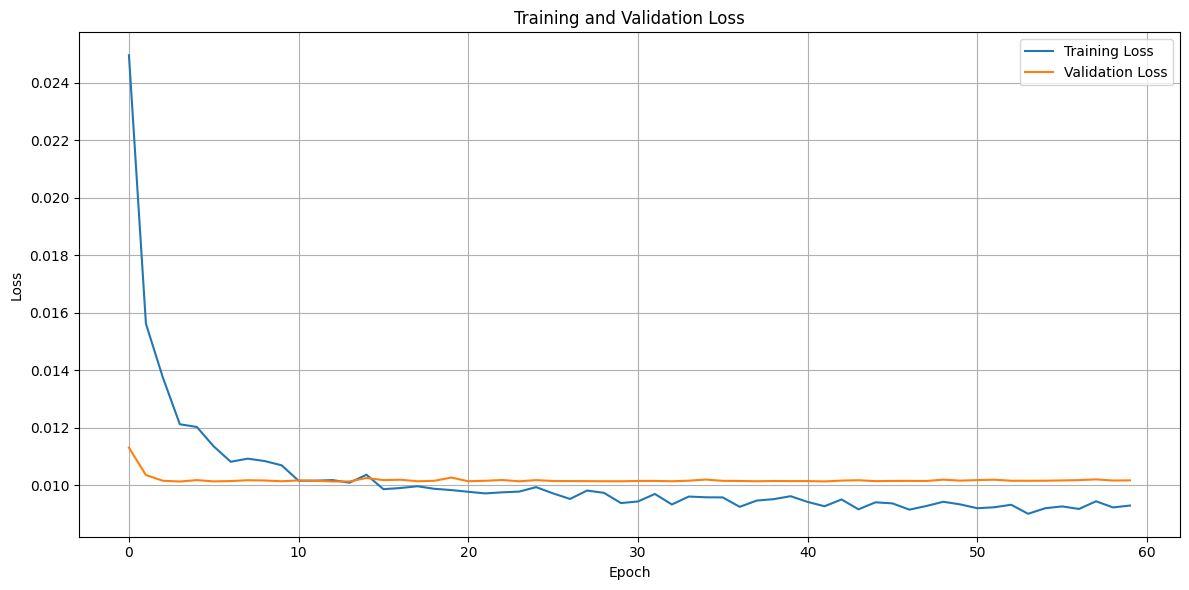

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MSE: 0.7690
RMSE: 0.8769
MAE: 0.6749
MAPE: 19.74%
R²: 0.6807


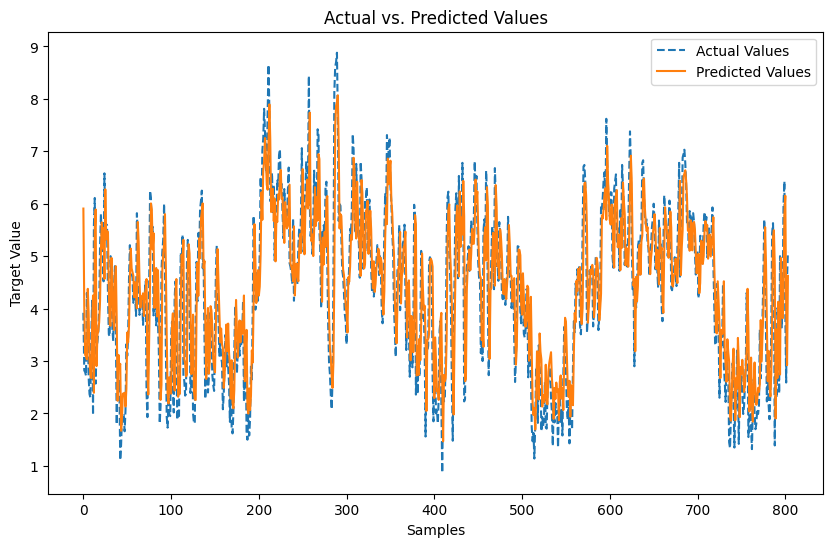

In [ ]:
!pip install optuna
import optuna
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load data
import pandas as pd

# Updated Google Sheets link setup
sheet_id = "1j_Euo80PrGckVDVr2hTG9zZebxJD0TSC"
sheet_name = "Sheet1"  # Update this if the sheet name is different

# Generate the CSV export link
csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

# Read the Google Sheet as CSV
df = pd.read_csv(csv_url)

# Backup original DataFrame
df_backup = df.copy()


# Set Date as the index
df = df.set_index('Date')

# Display the DataFrame (optional in scripts)
df.head()
df_backup=df.copy()

df = df.drop(columns=["YEAR", "MO", "DY"])

df

# Create lag features (past 3 lags for each variable)




df
df=df[["WS10M"]]
df = df.astype(float)
df
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df


################################################################################
K=1
# Number of lags to create
lags = K
lagged_features = create_lagged_features(df, lags)
lagged_features
print("Original DataFrame:")
print(df)


print("\nDataFrame with Lagged Features:")
print(lagged_features)
print(lagged_features.columns)
df2=lagged_features.dropna()
print(df2)
len(df2)
df2.isnull().sum()
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
df2
train_size = int(len(df2) * 0.8)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]



train_data
xtrain=train_data.drop(columns=['WS10M'])
xtest=test_data.drop(columns=['WS10M'])
xtrain
#ytrain=train_data['date','textile_exports']
ytrain=train_data["WS10M"]
ytest=test_data["WS10M"]
ytest
from sklearn.preprocessing import MinMaxScaler
xtrain.columns
ytrain
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)

'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''
xtrain
df1=pd.DataFrame(ytrain)
X_train_scaled
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)
X_train_scaled_df
df3= pd.concat([df1, X_train_scaled_df], axis=1)

df3
X_train_scaled_df
!pip install optuna
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Ensure y_train_scaled is a Pandas Series
y_train_scaled = pd.Series(y_train_scaled.ravel())


# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X, y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1, 4)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()
    elif optimizer_name == "SGD":
        optimizer = SGD()
    else:
        optimizer = RMSprop()

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesSplit
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Create and train a new model for each fold
        model = create_ann_model(trial, X, y)
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)
        val_scores.append(loss)

    return np.mean(val_scores)

# Step 4: Run the Optuna study with a fixed seed
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import matplotlib.pyplot as plt

# Set random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Retrieve the best hyperparameters from the study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'],
                input_dim=X_train_scaled_df.shape[1],
                activation=best_params['activation']))

# Hidden layers
for i in range(best_params['num_layers']):
    model.add(Dense(units=best_params[f'n_units_{i}'],
                    activation=best_params['activation']))
    model.add(Dropout(rate=best_params[f'dropout_rate_{i}']))

# Output layer (for regression)
model.add(Dense(units=1))

# Optimizer
if best_params['optimizer'] == 'Adam':
    optimizer = Adam()
elif best_params['optimizer'] == 'SGD':
    optimizer = SGD()
else:
    optimizer = RMSprop()

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,
    verbose=1
)

# Evaluate and print final loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}, Final MAE: {final_mae:.4f}")

# Plot training vs validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prepare the test DataFrame for prediction
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=xtest.columns, index=xtest.index)

# Generate predictions
test_predictions_scaled = model.predict(X_test_scaled_df)

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#test_predictions_scaled=
# Inverse transform predictions and actual values
#test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
#y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()


# 2

Original DataFrame:
                     WS10M
Date                      
2013-01-01 00:00:00   3.99
2013-01-02 00:00:00   4.25
2013-01-03 00:00:00   4.75
2013-01-04 00:00:00   5.74
2013-01-05 00:00:00   5.79
...                    ...
2023-12-27 00:00:00   6.43
2023-12-28 00:00:00   3.93
2023-12-29 00:00:00   2.59
2023-12-30 00:00:00   4.59
2023-12-31 00:00:00   5.08

[4017 rows x 1 columns]

DataFrame with Lagged Features:
                     WS10M  WS10M_lag_1  WS10M_lag_2
Date                                                
2013-01-01 00:00:00   3.99          NaN          NaN
2013-01-02 00:00:00   4.25         3.99          NaN
2013-01-03 00:00:00   4.75         4.25         3.99
2013-01-04 00:00:00   5.74         4.75         4.25
2013-01-05 00:00:00   5.79         5.74         4.75
...                    ...          ...          ...
2023-12-27 00:00:00   6.43         6.01         4.29
2023-12-28 00:00:00   3.93         6.43         6.01
2023-12-29 00:00:00   2.59         3.93  

[I 2025-07-09 09:27:20,821] A new study created in memory with name: no-name-2b1fb493-0805-4b94-8b3f-2c970abdb3e0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the

Best hyperparameters:  {'batch_size': 16, 'epochs': 70, 'input_units': 80, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 112, 'dropout_rate_0': 0.04357092138754676, 'n_units_1': 64, 'dropout_rate_1': 0.07866503716448248, 'optimizer': 'SGD'}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/70
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0389 - mae: 0.1411 - val_loss: 0.0130 - val_mae: 0.0894
Epoch 2/70
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0124 - mae: 0.0881 - val_loss: 0.0119 - val_mae: 0.0844
Epoch 3/70
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - mae: 0.0832 - val_loss: 0.0114 - val_mae: 0.0827
Epoch 4/70
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0110 - mae: 0.0818 - val_loss: 0.0111 - val_mae: 0.0816
Epoch 5/70
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0109 - mae: 0.0812 - val_loss: 0.0108 - val_mae: 0.0804
Epoch 6/70
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0108 - mae: 0.0798 - val_loss: 0.0107 - val_mae: 0.0800
Epoch 7/70
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0104 - mae: 0.0797 - val_loss: 0.0105 - val_mae: 0.0794
Epoch 8/70
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0102 - mae: 0.0782 - val_loss: 0.0105 - val_mae: 0.0793
Epoch 9/70
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - lo

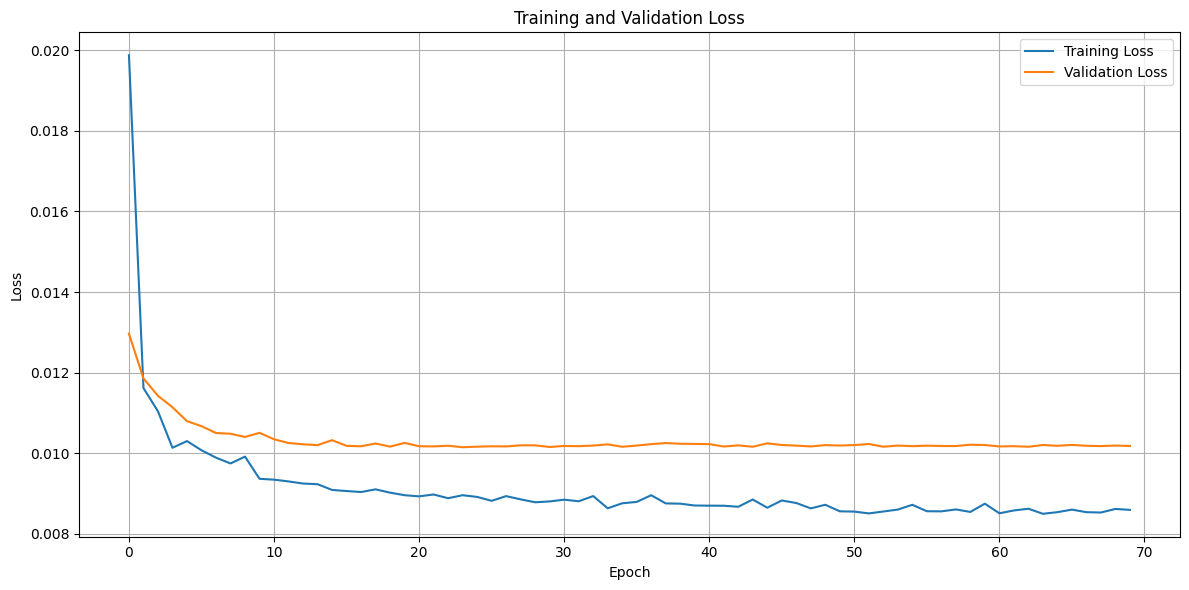

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MSE: 0.7639
RMSE: 0.8740
MAE: 0.6708
MAPE: 19.35%
R²: 0.6832


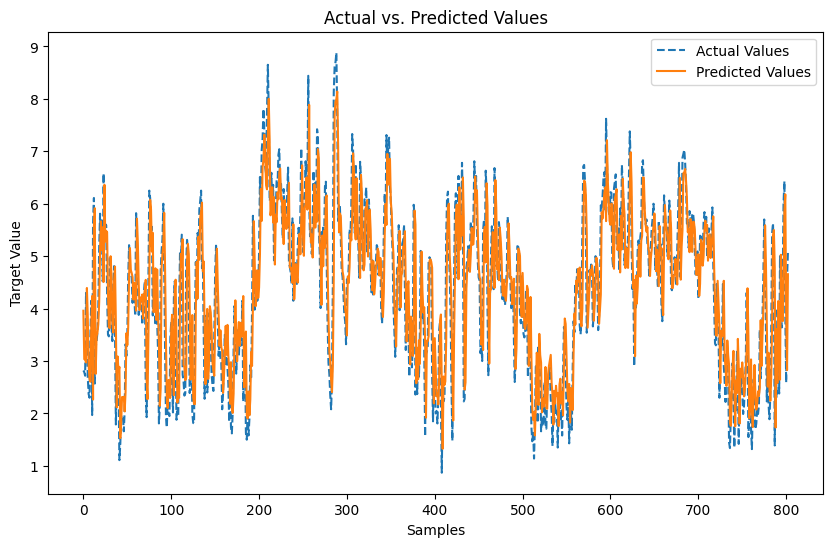

In [ ]:
!pip install optuna
import optuna
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load data
import pandas as pd

# Updated Google Sheets link setup
sheet_id = "1j_Euo80PrGckVDVr2hTG9zZebxJD0TSC"
sheet_name = "Sheet1"  # Update this if the sheet name is different

# Generate the CSV export link
csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

# Read the Google Sheet as CSV
df = pd.read_csv(csv_url)

# Backup original DataFrame
df_backup = df.copy()


# Set Date as the index
df = df.set_index('Date')

# Display the DataFrame (optional in scripts)
df.head()
df_backup=df.copy()

df = df.drop(columns=["YEAR", "MO", "DY"])

df

# Create lag features (past 3 lags for each variable)




df
df=df[["WS10M"]]
df = df.astype(float)
df
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df


################################################################################
K=2
# Number of lags to create
lags = K
lagged_features = create_lagged_features(df, lags)
lagged_features
print("Original DataFrame:")
print(df)


print("\nDataFrame with Lagged Features:")
print(lagged_features)
print(lagged_features.columns)
df2=lagged_features.dropna()
print(df2)
len(df2)
df2.isnull().sum()
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
df2
train_size = int(len(df2) * 0.8)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]



train_data
xtrain=train_data.drop(columns=['WS10M'])
xtest=test_data.drop(columns=['WS10M'])
xtrain
#ytrain=train_data['date','textile_exports']
ytrain=train_data["WS10M"]
ytest=test_data["WS10M"]
ytest
from sklearn.preprocessing import MinMaxScaler
xtrain.columns
ytrain
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)

'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''
xtrain
df1=pd.DataFrame(ytrain)
X_train_scaled
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)
X_train_scaled_df
df3= pd.concat([df1, X_train_scaled_df], axis=1)

df3
X_train_scaled_df
!pip install optuna
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Ensure y_train_scaled is a Pandas Series
y_train_scaled = pd.Series(y_train_scaled.ravel())


# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X, y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1, 4)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()
    elif optimizer_name == "SGD":
        optimizer = SGD()
    else:
        optimizer = RMSprop()

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesSplit
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Create and train a new model for each fold
        model = create_ann_model(trial, X, y)
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)
        val_scores.append(loss)

    return np.mean(val_scores)

# Step 4: Run the Optuna study with a fixed seed
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import matplotlib.pyplot as plt

# Set random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Retrieve the best hyperparameters from the study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'],
                input_dim=X_train_scaled_df.shape[1],
                activation=best_params['activation']))

# Hidden layers
for i in range(best_params['num_layers']):
    model.add(Dense(units=best_params[f'n_units_{i}'],
                    activation=best_params['activation']))
    model.add(Dropout(rate=best_params[f'dropout_rate_{i}']))

# Output layer (for regression)
model.add(Dense(units=1))

# Optimizer
if best_params['optimizer'] == 'Adam':
    optimizer = Adam()
elif best_params['optimizer'] == 'SGD':
    optimizer = SGD()
else:
    optimizer = RMSprop()

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,
    verbose=1
)

# Evaluate and print final loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}, Final MAE: {final_mae:.4f}")

# Plot training vs validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prepare the test DataFrame for prediction
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=xtest.columns, index=xtest.index)

# Generate predictions
test_predictions_scaled = model.predict(X_test_scaled_df)

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#test_predictions_scaled=
# Inverse transform predictions and actual values
#test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
#y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()


#3

Original DataFrame:
                     WS10M
Date                      
2013-01-01 00:00:00   3.99
2013-01-02 00:00:00   4.25
2013-01-03 00:00:00   4.75
2013-01-04 00:00:00   5.74
2013-01-05 00:00:00   5.79
...                    ...
2023-12-27 00:00:00   6.43
2023-12-28 00:00:00   3.93
2023-12-29 00:00:00   2.59
2023-12-30 00:00:00   4.59
2023-12-31 00:00:00   5.08

[4017 rows x 1 columns]

DataFrame with Lagged Features:
                     WS10M  WS10M_lag_1  WS10M_lag_2  WS10M_lag_3
Date                                                             
2013-01-01 00:00:00   3.99          NaN          NaN          NaN
2013-01-02 00:00:00   4.25         3.99          NaN          NaN
2013-01-03 00:00:00   4.75         4.25         3.99          NaN
2013-01-04 00:00:00   5.74         4.75         4.25         3.99
2013-01-05 00:00:00   5.79         5.74         4.75         4.25
...                    ...          ...          ...          ...
2023-12-27 00:00:00   6.43         6.01    

[I 2025-07-14 12:33:53,127] A new study created in memory with name: no-name-dd1095c2-bf8e-4b5f-a24f-bde2c4b0f50f
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the

Best hyperparameters:  {'batch_size': 16, 'epochs': 90, 'input_units': 64, 'activation': 'tanh', 'num_layers': 3, 'n_units_0': 80, 'dropout_rate_0': 0.07973798435142783, 'n_units_1': 64, 'dropout_rate_1': 0.11204061867321072, 'n_units_2': 32, 'dropout_rate_2': 0.0007250058963766959, 'optimizer': 'SGD'}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/90
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0499 - mae: 0.1641 - val_loss: 0.0156 - val_mae: 0.0989
Epoch 2/90
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0159 - mae: 0.0988 - val_loss: 0.0134 - val_mae: 0.0906
Epoch 3/90
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0137 - mae: 0.0910 - val_loss: 0.0124 - val_mae: 0.0865
Epoch 4/90
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0128 - mae: 0.0893 - val_loss: 0.0117 - val_mae: 0.0837
Epoch 5/90
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - mae: 0.0838 - val_loss: 0.0116 - val_mae: 0.0832
Epoch 6/90
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0107 - mae: 0.0809 - val_loss: 0.0109 - val_mae: 0.0808
Epoch 7/90
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0106 - mae: 0.0805 - val_loss: 0.0109 - val_mae: 0.0806
Epoch 8/90
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0103 - mae: 0.0789 - val_loss: 0.0106 - val_mae: 0.0796
Epoch 9/90
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

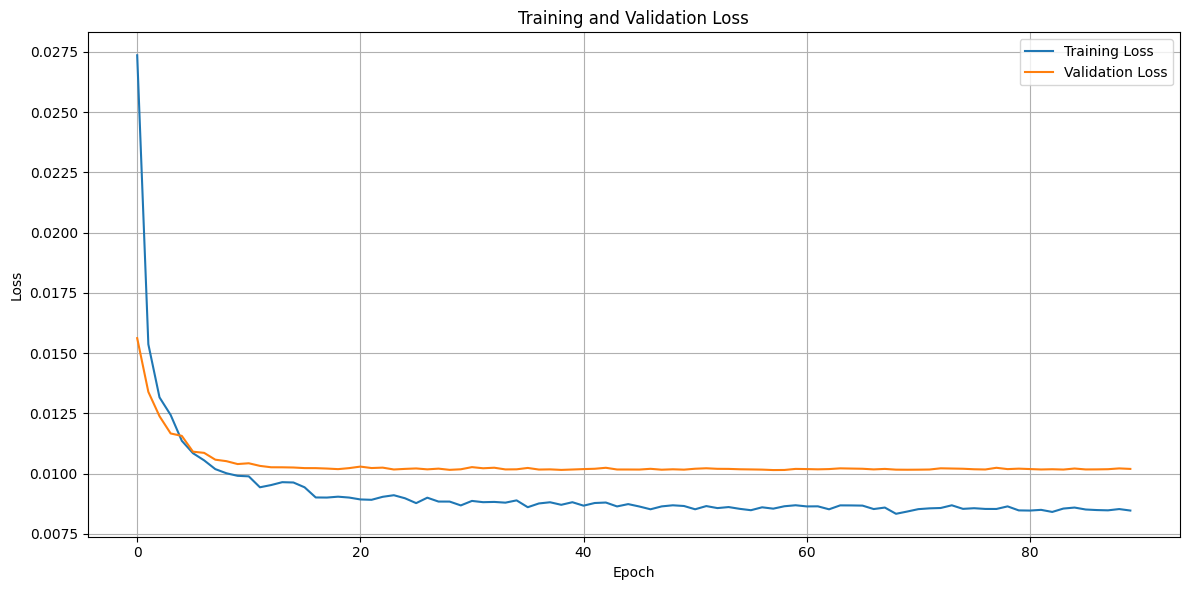

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MSE: 0.7546
RMSE: 0.8687
MAE: 0.6683
MAPE: 19.32%
R²: 0.6871


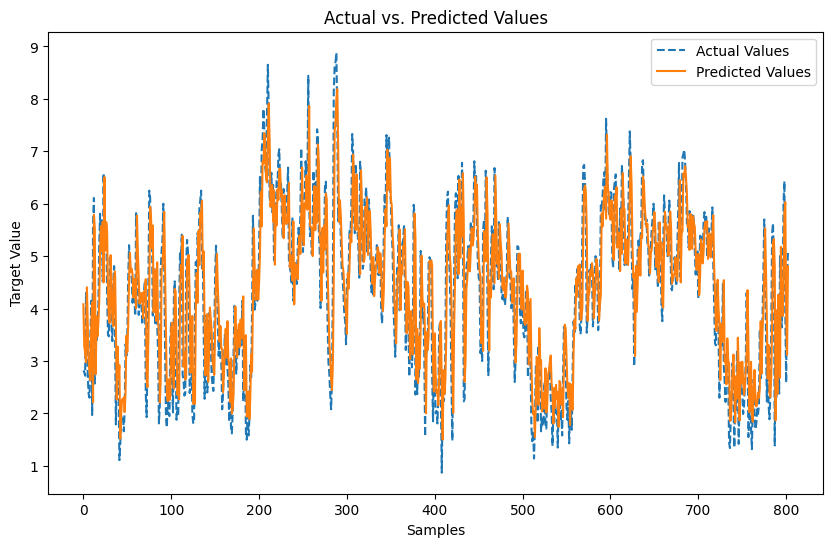

In [ ]:
!pip install optuna
import optuna
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load data
import pandas as pd

# Updated Google Sheets link setup
sheet_id = "1j_Euo80PrGckVDVr2hTG9zZebxJD0TSC"
sheet_name = "Sheet1"  # Update this if the sheet name is different

# Generate the CSV export link
csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

# Read the Google Sheet as CSV
df = pd.read_csv(csv_url)

# Backup original DataFrame
df_backup = df.copy()


# Set Date as the index
df = df.set_index('Date')

# Display the DataFrame (optional in scripts)
df.head()
df_backup=df.copy()

df = df.drop(columns=["YEAR", "MO", "DY"])

df

# Create lag features (past 3 lags for each variable)




df
df=df[["WS10M"]]
df = df.astype(float)
df
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df


################################################################################
K=3
# Number of lags to create
lags = K
lagged_features = create_lagged_features(df, lags)
lagged_features
print("Original DataFrame:")
print(df)


print("\nDataFrame with Lagged Features:")
print(lagged_features)
print(lagged_features.columns)
df2=lagged_features.dropna()
print(df2)
len(df2)
df2.isnull().sum()
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
df2
train_size = int(len(df2) * 0.8)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]



train_data
xtrain=train_data.drop(columns=['WS10M'])
xtest=test_data.drop(columns=['WS10M'])
xtrain
#ytrain=train_data['date','textile_exports']
ytrain=train_data["WS10M"]
ytest=test_data["WS10M"]
ytest
from sklearn.preprocessing import MinMaxScaler
xtrain.columns
ytrain
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)

'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''
xtrain
df1=pd.DataFrame(ytrain)
X_train_scaled
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)
X_train_scaled_df
df3= pd.concat([df1, X_train_scaled_df], axis=1)

df3
X_train_scaled_df
!pip install optuna
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Ensure y_train_scaled is a Pandas Series
y_train_scaled = pd.Series(y_train_scaled.ravel())


# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X, y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1, 4)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()
    elif optimizer_name == "SGD":
        optimizer = SGD()
    else:
        optimizer = RMSprop()

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesSplit
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Create and train a new model for each fold
        model = create_ann_model(trial, X, y)
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)
        val_scores.append(loss)

    return np.mean(val_scores)

# Step 4: Run the Optuna study with a fixed seed
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import matplotlib.pyplot as plt

# Set random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Retrieve the best hyperparameters from the study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'],
                input_dim=X_train_scaled_df.shape[1],
                activation=best_params['activation']))

# Hidden layers
for i in range(best_params['num_layers']):
    model.add(Dense(units=best_params[f'n_units_{i}'],
                    activation=best_params['activation']))
    model.add(Dropout(rate=best_params[f'dropout_rate_{i}']))

# Output layer (for regression)
model.add(Dense(units=1))

# Optimizer
if best_params['optimizer'] == 'Adam':
    optimizer = Adam()
elif best_params['optimizer'] == 'SGD':
    optimizer = SGD()
else:
    optimizer = RMSprop()

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,
    verbose=1
)

# Evaluate and print final loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}, Final MAE: {final_mae:.4f}")

# Plot training vs validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prepare the test DataFrame for prediction
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=xtest.columns, index=xtest.index)

# Generate predictions
test_predictions_scaled = model.predict(X_test_scaled_df)

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#test_predictions_scaled=
# Inverse transform predictions and actual values
#test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
#y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()


# 4

Original DataFrame:
                     WS10M
Date                      
2013-01-01 00:00:00   3.99
2013-01-02 00:00:00   4.25
2013-01-03 00:00:00   4.75
2013-01-04 00:00:00   5.74
2013-01-05 00:00:00   5.79
...                    ...
2023-12-27 00:00:00   6.43
2023-12-28 00:00:00   3.93
2023-12-29 00:00:00   2.59
2023-12-30 00:00:00   4.59
2023-12-31 00:00:00   5.08

[4017 rows x 1 columns]

DataFrame with Lagged Features:
                     WS10M  WS10M_lag_1  WS10M_lag_2  WS10M_lag_3  WS10M_lag_4
Date                                                                          
2013-01-01 00:00:00   3.99          NaN          NaN          NaN          NaN
2013-01-02 00:00:00   4.25         3.99          NaN          NaN          NaN
2013-01-03 00:00:00   4.75         4.25         3.99          NaN          NaN
2013-01-04 00:00:00   5.74         4.75         4.25         3.99          NaN
2013-01-05 00:00:00   5.79         5.74         4.75         4.25         3.99
...               

[I 2025-07-14 13:55:30,148] A new study created in memory with name: no-name-e33065d8-0d80-4a09-8fcf-ed0e5ae33611
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the

Best hyperparameters:  {'batch_size': 32, 'epochs': 90, 'input_units': 48, 'activation': 'tanh', 'num_layers': 3, 'n_units_0': 96, 'dropout_rate_0': 0.24462059110180798, 'n_units_1': 80, 'dropout_rate_1': 0.41991922809080656, 'n_units_2': 128, 'dropout_rate_2': 0.11833862568704487, 'optimizer': 'SGD'}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/90
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0540 - mae: 0.1770 - val_loss: 0.0207 - val_mae: 0.1153
Epoch 2/90
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0367 - mae: 0.1495 - val_loss: 0.0183 - val_mae: 0.1085
Epoch 3/90
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0273 - mae: 0.1291 - val_loss: 0.0162 - val_mae: 0.1009
Epoch 4/90
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0232 - mae: 0.1186 - val_loss: 0.0150 - val_mae: 0.0971
Epoch 5/90
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0210 - mae: 0.1134 - val_loss: 0.0141 - val_mae: 0.0940
Epoch 6/90
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0187 - mae: 0.1062 - val_loss: 0.0134 - val_mae: 0.0906
Epoch 7/90
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0175 - mae: 0.1044 - val_loss: 0.0128 - val_mae: 0.0889
Epoch 8/90
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0164 - mae: 0.1005 - val_loss: 0.0128 - val_mae: 0.0893
Epoch 9/90
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0155 - mae: 

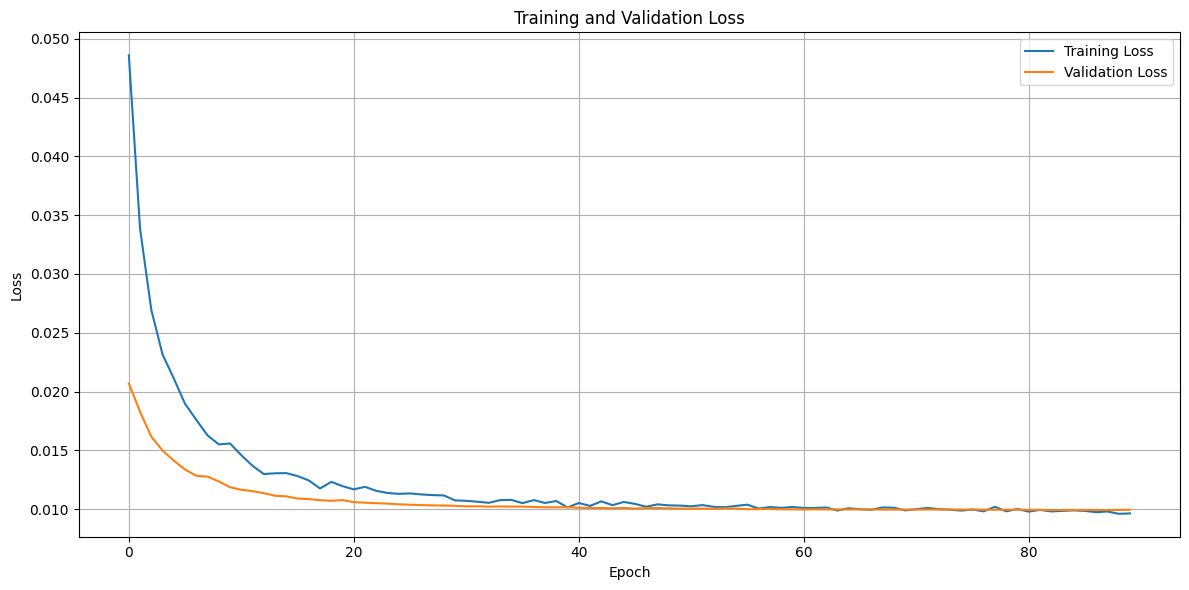

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
MSE: 0.7503
RMSE: 0.8662
MAE: 0.6679
MAPE: 19.41%
R²: 0.6888


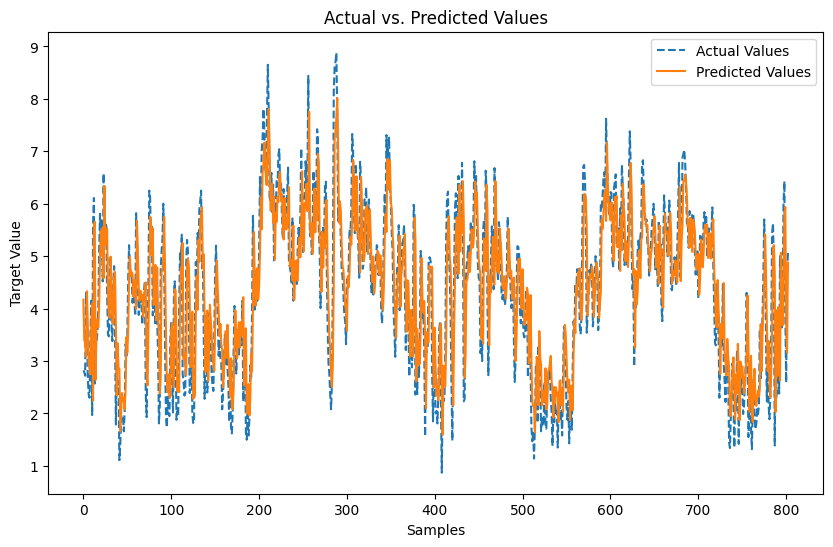

In [ ]:
!pip install optuna
import optuna
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load data
import pandas as pd

# Updated Google Sheets link setup
sheet_id = "1j_Euo80PrGckVDVr2hTG9zZebxJD0TSC"
sheet_name = "Sheet1"  # Update this if the sheet name is different

# Generate the CSV export link
csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

# Read the Google Sheet as CSV
df = pd.read_csv(csv_url)

# Backup original DataFrame
df_backup = df.copy()


# Set Date as the index
df = df.set_index('Date')

# Display the DataFrame (optional in scripts)
df.head()
df_backup=df.copy()

df = df.drop(columns=["YEAR", "MO", "DY"])

df

# Create lag features (past 3 lags for each variable)




df
df=df[["WS10M"]]
df = df.astype(float)
df
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df











################################################################################
K=4
# Number of lags to create
lags = K
lagged_features = create_lagged_features(df, lags)
lagged_features
print("Original DataFrame:")
print(df)


print("\nDataFrame with Lagged Features:")
print(lagged_features)
print(lagged_features.columns)
df2=lagged_features.dropna()
print(df2)
len(df2)
df2.isnull().sum()
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
df2
train_size = int(len(df2) * 0.8)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]



train_data
xtrain=train_data.drop(columns=['WS10M'])
xtest=test_data.drop(columns=['WS10M'])
xtrain
#ytrain=train_data['date','textile_exports']
ytrain=train_data["WS10M"]
ytest=test_data["WS10M"]
ytest
from sklearn.preprocessing import MinMaxScaler
xtrain.columns
ytrain
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)

'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''
xtrain
df1=pd.DataFrame(ytrain)
X_train_scaled
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)
X_train_scaled_df
df3= pd.concat([df1, X_train_scaled_df], axis=1)

df3
X_train_scaled_df
!pip install optuna
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Ensure y_train_scaled is a Pandas Series
y_train_scaled = pd.Series(y_train_scaled.ravel())


# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X, y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1, 4)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()
    elif optimizer_name == "SGD":
        optimizer = SGD()
    else:
        optimizer = RMSprop()

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesSplit
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Create and train a new model for each fold
        model = create_ann_model(trial, X, y)
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)
        val_scores.append(loss)

    return np.mean(val_scores)

# Step 4: Run the Optuna study with a fixed seed
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import matplotlib.pyplot as plt

# Set random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Retrieve the best hyperparameters from the study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'],
                input_dim=X_train_scaled_df.shape[1],
                activation=best_params['activation']))

# Hidden layers
for i in range(best_params['num_layers']):
    model.add(Dense(units=best_params[f'n_units_{i}'],
                    activation=best_params['activation']))
    model.add(Dropout(rate=best_params[f'dropout_rate_{i}']))

# Output layer (for regression)
model.add(Dense(units=1))

# Optimizer
if best_params['optimizer'] == 'Adam':
    optimizer = Adam()
elif best_params['optimizer'] == 'SGD':
    optimizer = SGD()
else:
    optimizer = RMSprop()

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,
    verbose=1
)

# Evaluate and print final loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}, Final MAE: {final_mae:.4f}")

# Plot training vs validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prepare the test DataFrame for prediction
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=xtest.columns, index=xtest.index)

# Generate predictions
test_predictions_scaled = model.predict(X_test_scaled_df)

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#test_predictions_scaled=
# Inverse transform predictions and actual values
#test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
#y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()


# 5

Original DataFrame:
                     WS10M
Date                      
2013-01-01 00:00:00   3.99
2013-01-02 00:00:00   4.25
2013-01-03 00:00:00   4.75
2013-01-04 00:00:00   5.74
2013-01-05 00:00:00   5.79
...                    ...
2023-12-27 00:00:00   6.43
2023-12-28 00:00:00   3.93
2023-12-29 00:00:00   2.59
2023-12-30 00:00:00   4.59
2023-12-31 00:00:00   5.08

[4017 rows x 1 columns]

DataFrame with Lagged Features:
                     WS10M  WS10M_lag_1  WS10M_lag_2  WS10M_lag_3  \
Date                                                                
2013-01-01 00:00:00   3.99          NaN          NaN          NaN   
2013-01-02 00:00:00   4.25         3.99          NaN          NaN   
2013-01-03 00:00:00   4.75         4.25         3.99          NaN   
2013-01-04 00:00:00   5.74         4.75         4.25         3.99   
2013-01-05 00:00:00   5.79         5.74         4.75         4.25   
...                    ...          ...          ...          ...   
2023-12-27 00:00:00

[I 2025-07-14 15:16:36,686] A new study created in memory with name: no-name-7ce5eb59-7b11-4639-9a7d-3df247e0bfec
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the

Best hyperparameters:  {'batch_size': 16, 'epochs': 80, 'input_units': 64, 'activation': 'tanh', 'num_layers': 3, 'n_units_0': 80, 'dropout_rate_0': 0.08159315199936486, 'n_units_1': 32, 'dropout_rate_1': 0.002959397921176131, 'n_units_2': 16, 'dropout_rate_2': 0.20114050700634822, 'optimizer': 'SGD'}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0466 - mae: 0.1602 - val_loss: 0.0164 - val_mae: 0.1013
Epoch 2/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0184 - mae: 0.1067 - val_loss: 0.0135 - val_mae: 0.0913
Epoch 3/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0156 - mae: 0.0984 - val_loss: 0.0127 - val_mae: 0.0887
Epoch 4/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0144 - mae: 0.0932 - val_loss: 0.0115 - val_mae: 0.0840
Epoch 5/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0134 - mae: 0.0901 - val_loss: 0.0110 - val_mae: 0.0821
Epoch 6/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0130 - mae: 0.0884 - val_loss: 0.0107 - val_mae: 0.0808
Epoch 7/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0121 - mae: 0.0854 - val_loss: 0.0104 - val_mae: 0.0794
Epoch 8/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0117 - mae: 0.0842 - val_loss: 0.0104 - val_mae: 0.0792
Epoch 9/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

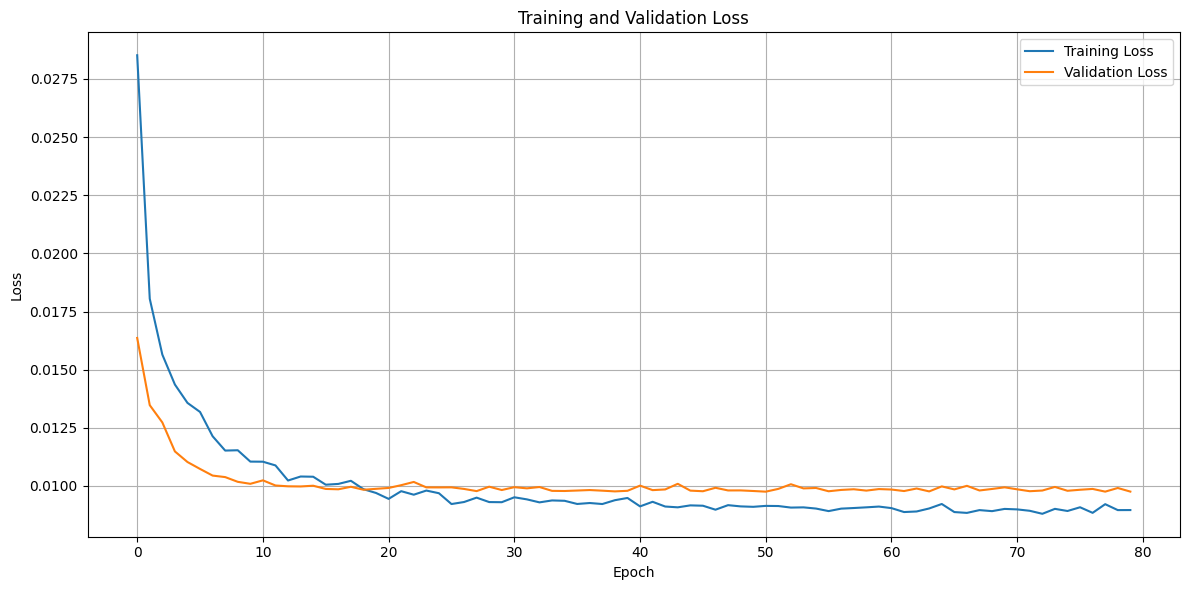

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MSE: 0.7503
RMSE: 0.8662
MAE: 0.6672
MAPE: 19.58%
R²: 0.6889


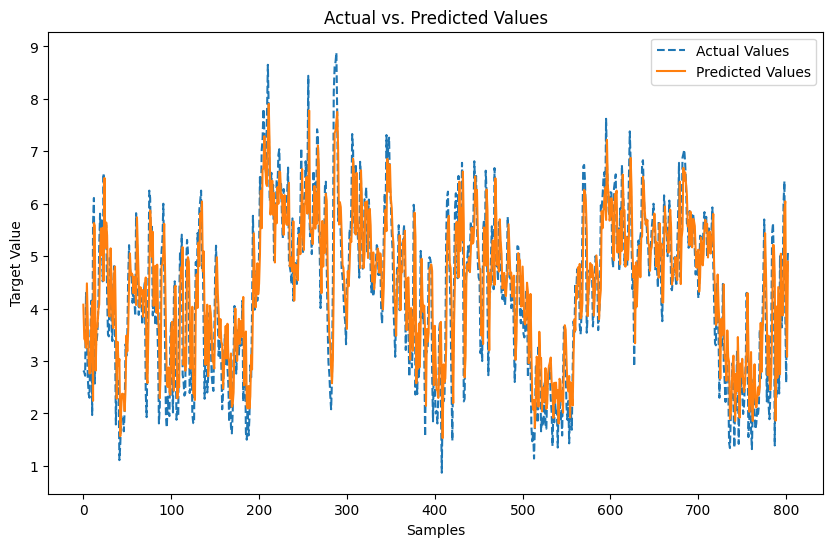

In [ ]:
!pip install optuna
import optuna
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load data
import pandas as pd

# Updated Google Sheets link setup
sheet_id = "1j_Euo80PrGckVDVr2hTG9zZebxJD0TSC"
sheet_name = "Sheet1"  # Update this if the sheet name is different

# Generate the CSV export link
csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

# Read the Google Sheet as CSV
df = pd.read_csv(csv_url)

# Backup original DataFrame
df_backup = df.copy()


# Set Date as the index
df = df.set_index('Date')

# Display the DataFrame (optional in scripts)
df.head()
df_backup=df.copy()

df = df.drop(columns=["YEAR", "MO", "DY"])

df

# Create lag features (past 3 lags for each variable)




df
df=df[["WS10M"]]
df = df.astype(float)
df
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df











################################################################################
K=5
# Number of lags to create
lags = K
lagged_features = create_lagged_features(df, lags)
lagged_features
print("Original DataFrame:")
print(df)


print("\nDataFrame with Lagged Features:")
print(lagged_features)
print(lagged_features.columns)
df2=lagged_features.dropna()
print(df2)
len(df2)
df2.isnull().sum()
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
df2
train_size = int(len(df2) * 0.8)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]



train_data
xtrain=train_data.drop(columns=['WS10M'])
xtest=test_data.drop(columns=['WS10M'])
xtrain
#ytrain=train_data['date','textile_exports']
ytrain=train_data["WS10M"]
ytest=test_data["WS10M"]
ytest
from sklearn.preprocessing import MinMaxScaler
xtrain.columns
ytrain
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)

'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''
xtrain
df1=pd.DataFrame(ytrain)
X_train_scaled
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)
X_train_scaled_df
df3= pd.concat([df1, X_train_scaled_df], axis=1)

df3
X_train_scaled_df
!pip install optuna
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Ensure y_train_scaled is a Pandas Series
y_train_scaled = pd.Series(y_train_scaled.ravel())


# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X, y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1, 4)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()
    elif optimizer_name == "SGD":
        optimizer = SGD()
    else:
        optimizer = RMSprop()

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesSplit
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Create and train a new model for each fold
        model = create_ann_model(trial, X, y)
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)
        val_scores.append(loss)

    return np.mean(val_scores)

# Step 4: Run the Optuna study with a fixed seed
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import matplotlib.pyplot as plt

# Set random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Retrieve the best hyperparameters from the study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'],
                input_dim=X_train_scaled_df.shape[1],
                activation=best_params['activation']))

# Hidden layers
for i in range(best_params['num_layers']):
    model.add(Dense(units=best_params[f'n_units_{i}'],
                    activation=best_params['activation']))
    model.add(Dropout(rate=best_params[f'dropout_rate_{i}']))

# Output layer (for regression)
model.add(Dense(units=1))

# Optimizer
if best_params['optimizer'] == 'Adam':
    optimizer = Adam()
elif best_params['optimizer'] == 'SGD':
    optimizer = SGD()
else:
    optimizer = RMSprop()

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,
    verbose=1
)

# Evaluate and print final loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}, Final MAE: {final_mae:.4f}")

# Plot training vs validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prepare the test DataFrame for prediction
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=xtest.columns, index=xtest.index)

# Generate predictions
test_predictions_scaled = model.predict(X_test_scaled_df)

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#test_predictions_scaled=
# Inverse transform predictions and actual values
#test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
#y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()


# 6

In [ ]:
!pip install optuna
import optuna
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load data
import pandas as pd

# Updated Google Sheets link setup
sheet_id = "1j_Euo80PrGckVDVr2hTG9zZebxJD0TSC"
sheet_name = "Sheet1"  # Update this if the sheet name is different

# Generate the CSV export link
csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

# Read the Google Sheet as CSV
df = pd.read_csv(csv_url)

# Backup original DataFrame
df_backup = df.copy()


# Set Date as the index
df = df.set_index('Date')

# Display the DataFrame (optional in scripts)
df.head()
df_backup=df.copy()

df = df.drop(columns=["YEAR", "MO", "DY"])

df

# Create lag features (past 3 lags for each variable)




df
df=df[["WS10M"]]
df = df.astype(float)
df
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df











################################################################################
K=6
# Number of lags to create
lags = K
lagged_features = create_lagged_features(df, lags)
lagged_features
print("Original DataFrame:")
print(df)


print("\nDataFrame with Lagged Features:")
print(lagged_features)
print(lagged_features.columns)
df2=lagged_features.dropna()
print(df2)
len(df2)
df2.isnull().sum()
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
df2
train_size = int(len(df2) * 0.8)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]



train_data
xtrain=train_data.drop(columns=['WS10M'])
xtest=test_data.drop(columns=['WS10M'])
xtrain
#ytrain=train_data['date','textile_exports']
ytrain=train_data["WS10M"]
ytest=test_data["WS10M"]
ytest
from sklearn.preprocessing import MinMaxScaler
xtrain.columns
ytrain
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)

'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''
xtrain
df1=pd.DataFrame(ytrain)
X_train_scaled
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)
X_train_scaled_df
df3= pd.concat([df1, X_train_scaled_df], axis=1)

df3
X_train_scaled_df
!pip install optuna
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Ensure y_train_scaled is a Pandas Series
y_train_scaled = pd.Series(y_train_scaled.ravel())


# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X, y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1, 4)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()
    elif optimizer_name == "SGD":
        optimizer = SGD()
    else:
        optimizer = RMSprop()

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesSplit
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Create and train a new model for each fold
        model = create_ann_model(trial, X, y)
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)
        val_scores.append(loss)

    return np.mean(val_scores)

# Step 4: Run the Optuna study with a fixed seed
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import matplotlib.pyplot as plt

# Set random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Retrieve the best hyperparameters from the study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'],
                input_dim=X_train_scaled_df.shape[1],
                activation=best_params['activation']))

# Hidden layers
for i in range(best_params['num_layers']):
    model.add(Dense(units=best_params[f'n_units_{i}'],
                    activation=best_params['activation']))
    model.add(Dropout(rate=best_params[f'dropout_rate_{i}']))

# Output layer (for regression)
model.add(Dense(units=1))

# Optimizer
if best_params['optimizer'] == 'Adam':
    optimizer = Adam()
elif best_params['optimizer'] == 'SGD':
    optimizer = SGD()
else:
    optimizer = RMSprop()

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,
    verbose=1
)

# Evaluate and print final loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}, Final MAE: {final_mae:.4f}")

# Plot training vs validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prepare the test DataFrame for prediction
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=xtest.columns, index=xtest.index)

# Generate predictions
test_predictions_scaled = model.predict(X_test_scaled_df)

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#test_predictions_scaled=
# Inverse transform predictions and actual values
#test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
#y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()


# 7

Original DataFrame:
                     WS10M
Date                      
2013-01-01 00:00:00   3.99
2013-01-02 00:00:00   4.25
2013-01-03 00:00:00   4.75
2013-01-04 00:00:00   5.74
2013-01-05 00:00:00   5.79
...                    ...
2023-12-27 00:00:00   6.43
2023-12-28 00:00:00   3.93
2023-12-29 00:00:00   2.59
2023-12-30 00:00:00   4.59
2023-12-31 00:00:00   5.08

[4017 rows x 1 columns]

DataFrame with Lagged Features:
                     WS10M  WS10M_lag_1  WS10M_lag_2  WS10M_lag_3  \
Date                                                                
2013-01-01 00:00:00   3.99          NaN          NaN          NaN   
2013-01-02 00:00:00   4.25         3.99          NaN          NaN   
2013-01-03 00:00:00   4.75         4.25         3.99          NaN   
2013-01-04 00:00:00   5.74         4.75         4.25         3.99   
2013-01-05 00:00:00   5.79         5.74         4.75         4.25   
...                    ...          ...          ...          ...   
2023-12-27 00:00:00

[I 2025-07-14 16:32:25,391] A new study created in memory with name: no-name-00336fbb-b269-4637-98a4-686416b58d44
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the

Best hyperparameters:  {'batch_size': 64, 'epochs': 100, 'input_units': 80, 'activation': 'tanh', 'num_layers': 3, 'n_units_0': 48, 'dropout_rate_0': 0.4042654699113212, 'n_units_1': 80, 'dropout_rate_1': 0.20899303729446764, 'n_units_2': 48, 'dropout_rate_2': 0.2130424192712069, 'optimizer': 'Adam'}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0676 - mae: 0.1933 - val_loss: 0.0108 - val_mae: 0.0805
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0172 - mae: 0.1020 - val_loss: 0.0100 - val_mae: 0.0786
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0151 - mae: 0.0948 - val_loss: 0.0106 - val_mae: 0.0793
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0138 - mae: 0.0926 - val_loss: 0.0095 - val_mae: 0.0755
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0136 - mae: 0.0912 - val_loss: 0.0104 - val_mae: 0.0789
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0122 - mae: 0.0863 - val_loss: 0.0096 - val_mae: 0.0759
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0124 - mae: 0.0872 - val_loss: 0.0095 - val_mae: 0.0761
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0121 - mae: 0.0865 - val_loss: 0.0097 - val_mae: 0.0764
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.01

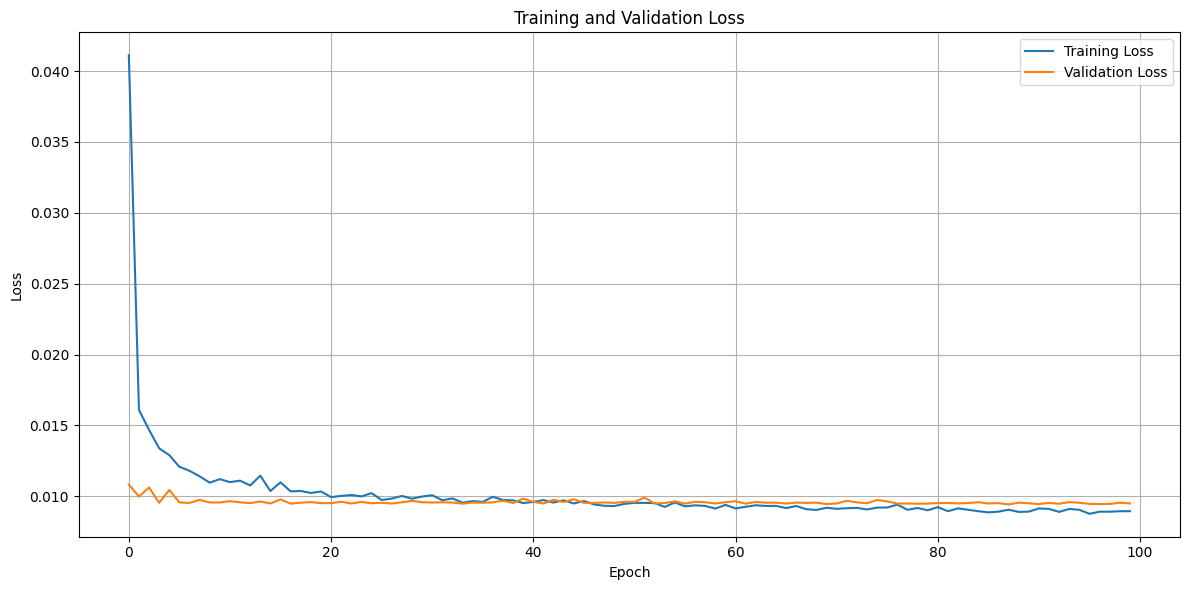

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
MSE: 0.7345
RMSE: 0.8570
MAE: 0.6612
MAPE: 18.99%
R²: 0.6954


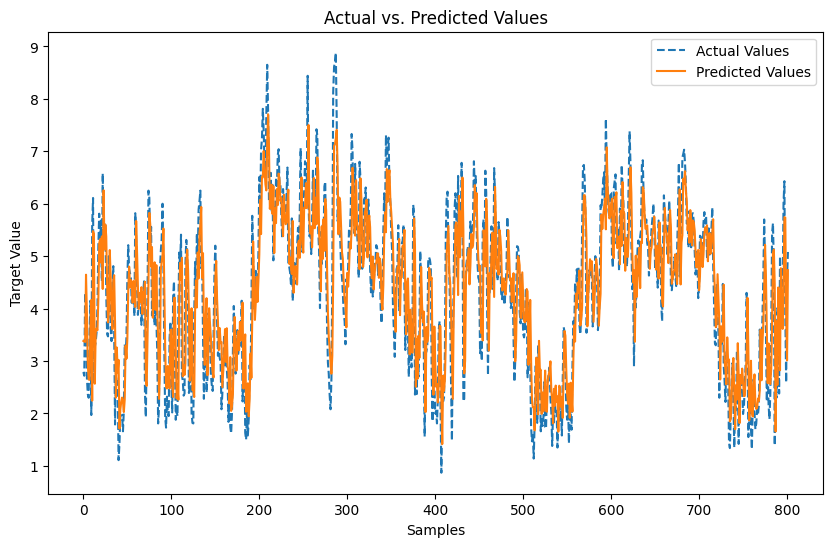

In [ ]:
!pip install optuna
import optuna
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load data
import pandas as pd

# Updated Google Sheets link setup
sheet_id = "1j_Euo80PrGckVDVr2hTG9zZebxJD0TSC"
sheet_name = "Sheet1"  # Update this if the sheet name is different

# Generate the CSV export link
csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

# Read the Google Sheet as CSV
df = pd.read_csv(csv_url)

# Backup original DataFrame
df_backup = df.copy()


# Set Date as the index
df = df.set_index('Date')

# Display the DataFrame (optional in scripts)
df.head()
df_backup=df.copy()

df = df.drop(columns=["YEAR", "MO", "DY"])

df

# Create lag features (past 3 lags for each variable)




df
df=df[["WS10M"]]
df = df.astype(float)
df
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df











################################################################################
K=7
# Number of lags to create
lags = K
lagged_features = create_lagged_features(df, lags)
lagged_features
print("Original DataFrame:")
print(df)


print("\nDataFrame with Lagged Features:")
print(lagged_features)
print(lagged_features.columns)
df2=lagged_features.dropna()
print(df2)
len(df2)
df2.isnull().sum()
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
df2
train_size = int(len(df2) * 0.8)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]



train_data
xtrain=train_data.drop(columns=['WS10M'])
xtest=test_data.drop(columns=['WS10M'])
xtrain
#ytrain=train_data['date','textile_exports']
ytrain=train_data["WS10M"]
ytest=test_data["WS10M"]
ytest
from sklearn.preprocessing import MinMaxScaler
xtrain.columns
ytrain
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)

'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''
xtrain
df1=pd.DataFrame(ytrain)
X_train_scaled
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)
X_train_scaled_df
df3= pd.concat([df1, X_train_scaled_df], axis=1)

df3
X_train_scaled_df
!pip install optuna
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Ensure y_train_scaled is a Pandas Series
y_train_scaled = pd.Series(y_train_scaled.ravel())


# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X, y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1, 4)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()
    elif optimizer_name == "SGD":
        optimizer = SGD()
    else:
        optimizer = RMSprop()

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesSplit
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Create and train a new model for each fold
        model = create_ann_model(trial, X, y)
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)
        val_scores.append(loss)

    return np.mean(val_scores)

# Step 4: Run the Optuna study with a fixed seed
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import matplotlib.pyplot as plt

# Set random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Retrieve the best hyperparameters from the study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'],
                input_dim=X_train_scaled_df.shape[1],
                activation=best_params['activation']))

# Hidden layers
for i in range(best_params['num_layers']):
    model.add(Dense(units=best_params[f'n_units_{i}'],
                    activation=best_params['activation']))
    model.add(Dropout(rate=best_params[f'dropout_rate_{i}']))

# Output layer (for regression)
model.add(Dense(units=1))

# Optimizer
if best_params['optimizer'] == 'Adam':
    optimizer = Adam()
elif best_params['optimizer'] == 'SGD':
    optimizer = SGD()
else:
    optimizer = RMSprop()

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,
    verbose=1
)

# Evaluate and print final loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}, Final MAE: {final_mae:.4f}")

# Plot training vs validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prepare the test DataFrame for prediction
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=xtest.columns, index=xtest.index)

# Generate predictions
test_predictions_scaled = model.predict(X_test_scaled_df)

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#test_predictions_scaled=
# Inverse transform predictions and actual values
#test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
#y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()


# 8

Original DataFrame:
                     WS10M
Date                      
2013-01-01 00:00:00   3.99
2013-01-02 00:00:00   4.25
2013-01-03 00:00:00   4.75
2013-01-04 00:00:00   5.74
2013-01-05 00:00:00   5.79
...                    ...
2023-12-27 00:00:00   6.43
2023-12-28 00:00:00   3.93
2023-12-29 00:00:00   2.59
2023-12-30 00:00:00   4.59
2023-12-31 00:00:00   5.08

[4017 rows x 1 columns]

DataFrame with Lagged Features:
                     WS10M  WS10M_lag_1  WS10M_lag_2  WS10M_lag_3  \
Date                                                                
2013-01-01 00:00:00   3.99          NaN          NaN          NaN   
2013-01-02 00:00:00   4.25         3.99          NaN          NaN   
2013-01-03 00:00:00   4.75         4.25         3.99          NaN   
2013-01-04 00:00:00   5.74         4.75         4.25         3.99   
2013-01-05 00:00:00   5.79         5.74         4.75         4.25   
...                    ...          ...          ...          ...   
2023-12-27 00:00:00

[I 2025-07-14 17:38:03,386] A new study created in memory with name: no-name-7fe78a87-906b-48bf-bb84-f24907684524
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the

Best hyperparameters:  {'batch_size': 16, 'epochs': 90, 'input_units': 112, 'activation': 'tanh', 'num_layers': 3, 'n_units_0': 128, 'dropout_rate_0': 0.21912983856406917, 'n_units_1': 64, 'dropout_rate_1': 0.13172312246297313, 'n_units_2': 80, 'dropout_rate_2': 0.26889167065475833, 'optimizer': 'SGD'}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/90
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0495 - mae: 0.1706 - val_loss: 0.0139 - val_mae: 0.0926
Epoch 2/90
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0255 - mae: 0.1234 - val_loss: 0.0120 - val_mae: 0.0867
Epoch 3/90
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0192 - mae: 0.1070 - val_loss: 0.0115 - val_mae: 0.0845
Epoch 4/90
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0173 - mae: 0.1032 - val_loss: 0.0110 - val_mae: 0.0824
Epoch 5/90
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0155 - mae: 0.0966 - val_loss: 0.0108 - val_mae: 0.0813
Epoch 6/90
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0150 - mae: 0.0955 - val_loss: 0.0105 - val_mae: 0.0799
Epoch 7/90
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0139 - mae: 0.0917 - val_loss: 0.0104 - val_mae: 0.0794
Epoch 8/90
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0132 - mae: 0.0901 - val_loss: 0.0103 - val_mae: 0.0792
Epoch 9/90
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - lo

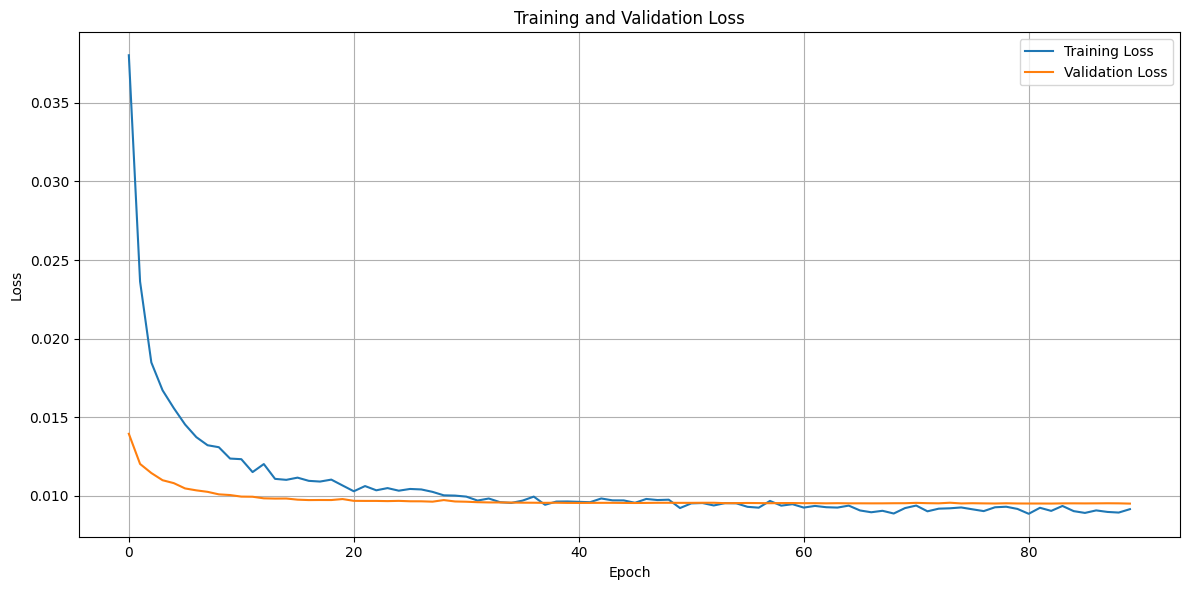

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
MSE: 0.7305
RMSE: 0.8547
MAE: 0.6594
MAPE: 18.88%
R²: 0.6971


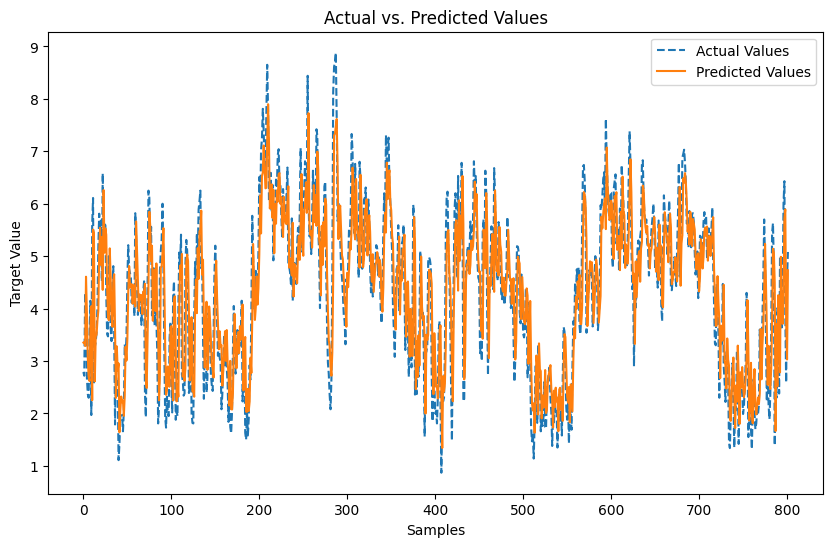

In [ ]:
!pip install optuna
import optuna
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load data
import pandas as pd

# Updated Google Sheets link setup
sheet_id = "1j_Euo80PrGckVDVr2hTG9zZebxJD0TSC"
sheet_name = "Sheet1"  # Update this if the sheet name is different

# Generate the CSV export link
csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

# Read the Google Sheet as CSV
df = pd.read_csv(csv_url)

# Backup original DataFrame
df_backup = df.copy()


# Set Date as the index
df = df.set_index('Date')

# Display the DataFrame (optional in scripts)
df.head()
df_backup=df.copy()

df = df.drop(columns=["YEAR", "MO", "DY"])

df

# Create lag features (past 3 lags for each variable)




df
df=df[["WS10M"]]
df = df.astype(float)
df
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df











################################################################################
K=8
# Number of lags to create
lags = K
lagged_features = create_lagged_features(df, lags)
lagged_features
print("Original DataFrame:")
print(df)


print("\nDataFrame with Lagged Features:")
print(lagged_features)
print(lagged_features.columns)
df2=lagged_features.dropna()
print(df2)
len(df2)
df2.isnull().sum()
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
df2
train_size = int(len(df2) * 0.8)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]



train_data
xtrain=train_data.drop(columns=['WS10M'])
xtest=test_data.drop(columns=['WS10M'])
xtrain
#ytrain=train_data['date','textile_exports']
ytrain=train_data["WS10M"]
ytest=test_data["WS10M"]
ytest
from sklearn.preprocessing import MinMaxScaler
xtrain.columns
ytrain
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)

'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''
xtrain
df1=pd.DataFrame(ytrain)
X_train_scaled
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)
X_train_scaled_df
df3= pd.concat([df1, X_train_scaled_df], axis=1)

df3
X_train_scaled_df
!pip install optuna
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Ensure y_train_scaled is a Pandas Series
y_train_scaled = pd.Series(y_train_scaled.ravel())


# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X, y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1, 4)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()
    elif optimizer_name == "SGD":
        optimizer = SGD()
    else:
        optimizer = RMSprop()

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesSplit
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Create and train a new model for each fold
        model = create_ann_model(trial, X, y)
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)
        val_scores.append(loss)

    return np.mean(val_scores)

# Step 4: Run the Optuna study with a fixed seed
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import matplotlib.pyplot as plt

# Set random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Retrieve the best hyperparameters from the study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'],
                input_dim=X_train_scaled_df.shape[1],
                activation=best_params['activation']))

# Hidden layers
for i in range(best_params['num_layers']):
    model.add(Dense(units=best_params[f'n_units_{i}'],
                    activation=best_params['activation']))
    model.add(Dropout(rate=best_params[f'dropout_rate_{i}']))

# Output layer (for regression)
model.add(Dense(units=1))

# Optimizer
if best_params['optimizer'] == 'Adam':
    optimizer = Adam()
elif best_params['optimizer'] == 'SGD':
    optimizer = SGD()
else:
    optimizer = RMSprop()

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,
    verbose=1
)

# Evaluate and print final loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}, Final MAE: {final_mae:.4f}")

# Plot training vs validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prepare the test DataFrame for prediction
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=xtest.columns, index=xtest.index)

# Generate predictions
test_predictions_scaled = model.predict(X_test_scaled_df)

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#test_predictions_scaled=
# Inverse transform predictions and actual values
#test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
#y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()


# 9

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 17.7 MB/s eta 0:00:00
Original DataFrame:
                     WS10M
Date                      
2013-01-01 00:00:00   3.99
2013-01-02 00:00:00   4.25
2013-01-03 00:00:00   4.75
2013-01-04 00:00:00   5.74
2013-01-05 00:00:00   5.79
...                    ...
2023-12-27 00:00:00   6.43
2023-12-28 00:00:00   3.93
2023-12-29 00:00:00   2.59
2023-12-30 00:00:00   4.59
2023-12-31 00:00:00   5.08

[4017 rows x 1 columns]

DataFrame with Lagged Features:
                     WS10M  WS10M_lag_1  WS10M_lag_2  WS10M_lag_3  \
Date                                                                
2013-01-01 00:00:00   3.99          NaN          NaN          NaN   
2013-01-02 00:00:00   4.25         3.99          NaN          NaN   
2013-01-03 00:00:00   4.75         4.25         3.99          NaN   
2013-01-04 00:00:00   5.74         4.75         4.25         3.99

[I 2025-07-15 02:47:11,303] A new study created in memory with name: no-name-ea309459-5399-4fe0-9f46-e1890ef21449
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the

Best hyperparameters:  {'batch_size': 16, 'epochs': 80, 'input_units': 64, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 64, 'dropout_rate_0': 0.05800026209816907, 'n_units_1': 16, 'dropout_rate_1': 0.02797015961506206, 'optimizer': 'SGD'}
Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0260 - mae: 0.1243 - val_loss: 0.0150 - val_mae: 0.0949
Epoch 2/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0167 - mae: 0.1003 - val_loss: 0.0124 - val_mae: 0.0864
Epoch 3/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0132 - mae: 0.0898 - val_loss: 0.0113 - val_mae: 0.0828
Epoch 4/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0121 - mae: 0.0862 - val_loss: 0.0111 - val_mae: 0.0822
Epoch 5/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - mae: 0.0845 - val_loss: 0.0107 - val_mae: 0.0806
Epoch 6/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0110 - mae: 0.0828 - val_loss: 0.0101 - val_mae: 0.0784
Epoch 7/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0108 - mae: 0.0813 - val_loss: 0.0102 - val_mae: 0.0787
Epoch 8/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0101 - mae: 0.0788 - val_loss: 0.0107 - val_mae: 0.0810
Epoch 9/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0101 

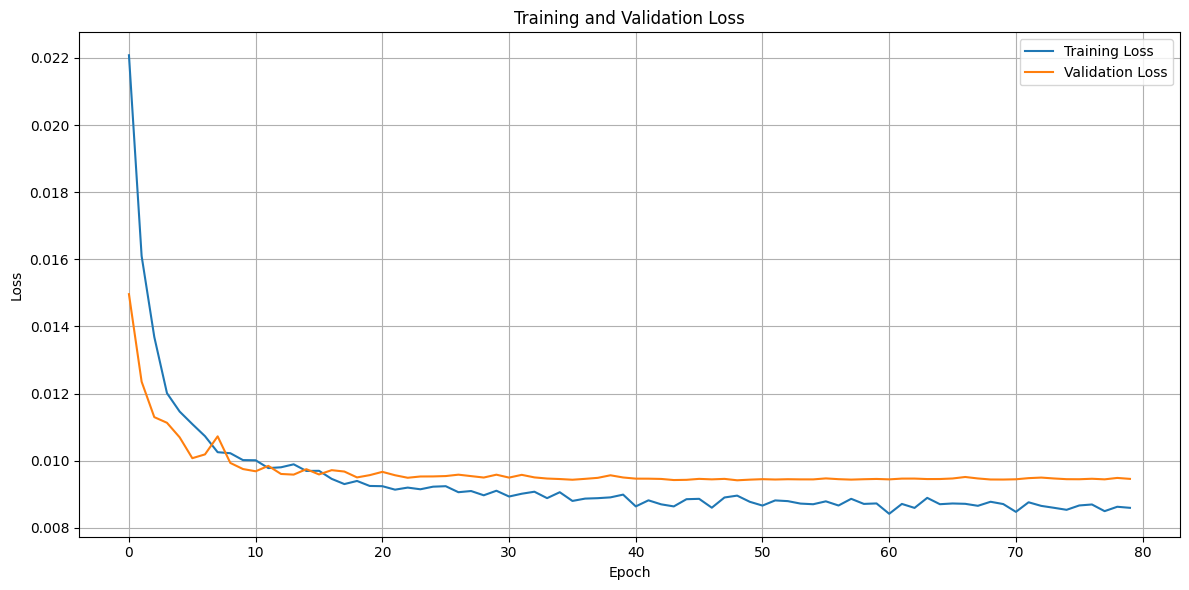

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE: 0.7306
RMSE: 0.8547
MAE: 0.6569
MAPE: 18.48%
R²: 0.6971


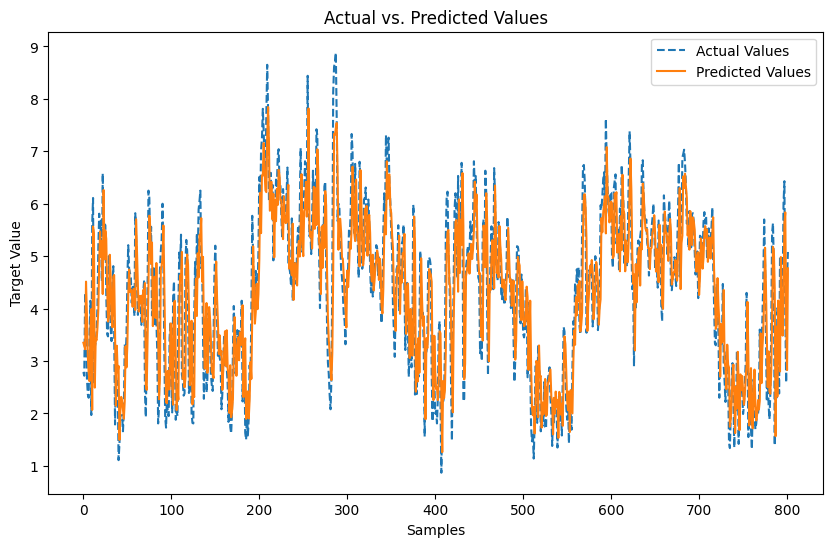

In [ ]:
!pip install optuna
import optuna
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load data
import pandas as pd

# Updated Google Sheets link setup
sheet_id = "1j_Euo80PrGckVDVr2hTG9zZebxJD0TSC"
sheet_name = "Sheet1"  # Update this if the sheet name is different

# Generate the CSV export link
csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

# Read the Google Sheet as CSV
df = pd.read_csv(csv_url)

# Backup original DataFrame
df_backup = df.copy()


# Set Date as the index
df = df.set_index('Date')

# Display the DataFrame (optional in scripts)
df.head()
df_backup=df.copy()

df = df.drop(columns=["YEAR", "MO", "DY"])

df

# Create lag features (past 3 lags for each variable)




df
df=df[["WS10M"]]
df = df.astype(float)
df
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df











################################################################################
K=9
# Number of lags to create
lags = K
lagged_features = create_lagged_features(df, lags)
lagged_features
print("Original DataFrame:")
print(df)


print("\nDataFrame with Lagged Features:")
print(lagged_features)
print(lagged_features.columns)
df2=lagged_features.dropna()
print(df2)
len(df2)
df2.isnull().sum()
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
df2
train_size = int(len(df2) * 0.8)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]



train_data
xtrain=train_data.drop(columns=['WS10M'])
xtest=test_data.drop(columns=['WS10M'])
xtrain
#ytrain=train_data['date','textile_exports']
ytrain=train_data["WS10M"]
ytest=test_data["WS10M"]
ytest
from sklearn.preprocessing import MinMaxScaler
xtrain.columns
ytrain
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)

'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''
xtrain
df1=pd.DataFrame(ytrain)
X_train_scaled
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)
X_train_scaled_df
df3= pd.concat([df1, X_train_scaled_df], axis=1)

df3
X_train_scaled_df
!pip install optuna
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Ensure y_train_scaled is a Pandas Series
y_train_scaled = pd.Series(y_train_scaled.ravel())


# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X, y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1, 4)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()
    elif optimizer_name == "SGD":
        optimizer = SGD()
    else:
        optimizer = RMSprop()

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesSplit
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Create and train a new model for each fold
        model = create_ann_model(trial, X, y)
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)
        val_scores.append(loss)

    return np.mean(val_scores)

# Step 4: Run the Optuna study with a fixed seed
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import matplotlib.pyplot as plt

# Set random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Retrieve the best hyperparameters from the study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'],
                input_dim=X_train_scaled_df.shape[1],
                activation=best_params['activation']))

# Hidden layers
for i in range(best_params['num_layers']):
    model.add(Dense(units=best_params[f'n_units_{i}'],
                    activation=best_params['activation']))
    model.add(Dropout(rate=best_params[f'dropout_rate_{i}']))

# Output layer (for regression)
model.add(Dense(units=1))

# Optimizer
if best_params['optimizer'] == 'Adam':
    optimizer = Adam()
elif best_params['optimizer'] == 'SGD':
    optimizer = SGD()
else:
    optimizer = RMSprop()

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,
    verbose=1
)

# Evaluate and print final loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}, Final MAE: {final_mae:.4f}")

# Plot training vs validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prepare the test DataFrame for prediction
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=xtest.columns, index=xtest.index)

# Generate predictions
test_predictions_scaled = model.predict(X_test_scaled_df)

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#test_predictions_scaled=
# Inverse transform predictions and actual values
#test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
#y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()
